<a href="https://colab.research.google.com/github/samikhenissi/TheoretUserModeling/blob/master/Simulation_Theor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
#from bias_metrics import *
import tqdm
from numba import jit
import matplotlib.pyplot as plt

In [ ]:
!pip install numba

## 1- Defining MF learning function

In [ ]:
@jit
def matrix_factorization(R , K=10, nsteps=300, alpha=0.001, beta=0.01 ): #this funcion train the MF model Using gradient decent 
    P = np.random.rand(len(R),K)
    Q = np.random.rand(len(R[0]),K)
    Q = Q.T
    steps = nsteps
    N,M = R.shape
    for step in range(steps):
        for i in range(N):
            for j in range(M):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k] ) 
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j] ) 
                    
    return P, Q.T 



## 2 - Importing Dataset (link also provided in the paper)

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2020-06-01 14:08:19--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  14.7MB/s    in 0.4s    

2020-06-01 14:08:19 (14.7 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
################# MovieLens

data = pd.read_csv("ml-1m/ratings.dat",sep='::',names="UserId,movieID,Rating,Timestamp".split(","))
n_users = data.UserId.max()
n_items = data.movieID.max()

#Create the full data matrix (has training and testing)   
full_data = np.zeros((n_users, n_items))
for line in data.itertuples():
    full_data[line[1]-1, line[2]-1] = line[3]

#Save a copy to be able to reset the data matrix    
Reset_data = np.copy(full_data)
## complete matrix of ratings
P_mov,Q_mov = matrix_factorization(full_data , K=10, nsteps=300, alpha=0.001, beta=0.01 )
R_hat_MF = np.dot(P_mov,Q_mov.T)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
### remove training data: 
R_hat_MF = R_hat_MF * ((full_data==0)*1)

## Getting all the genres in the dataset as a unique list

In [ ]:
movie = pd.read_csv("ml-1m/movies.dat",sep='::',names="movieID::Name::Genre".split("::"))
movie = movie.set_index('movieID')
new_index = pd.Index(np.arange(1,full_data.shape[1]+1), name="movieID")
movie = movie.reindex(new_index).reset_index()
movie.fillna("unkown",inplace = True)
movie['Genre'] = movie['Genre'].apply(lambda x: x.split("|"))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
genres = []
genres_df = movie['Genre']
for l in tqdm.tqdm(genres_df):
    for g in l:
        if g not in genres:
            genres += [g]

100%|██████████| 3952/3952 [00:00<00:00, 583391.03it/s]


In [ ]:
genres

['Animation',
 "Children's",
 'Comedy',
 'Adventure',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Sci-Fi',
 'Documentary',
 'War',
 'Musical',
 'Mystery',
 'unkown',
 'Film-Noir',
 'Western']

## Functions to be used in experiments

In [ ]:
def calc_seen(user_ratings):  # Return list of seen groups
    i=1
    genres_seen = []
    for c in user_ratings:
        if c !=0:
            for g in movie[movie['movieID']==i]['Genre'].item():
                if g not in genres_seen:
                    genres_seen += [g]
        i+=1
        
    return genres_seen

In [ ]:
def calc_mean(user_ratings_pred,genres_seen):  # return mean ratings of seen groups
    i=1
    tot_seen = 0
    tot_unseen = 0
    num_seen=0
    num_unseen = 0
    for c in user_ratings_pred:
        if c !=0:
            genres = movie[movie['movieID']==i]['Genre'].item()
            if len(list(set(genres) & set(genres_seen))) >0 :
                tot_seen +=c
                num_seen +=1
            else:
                tot_unseen += c
                num_unseen += 1
                
        i+=1
        
    return [tot_seen/num_seen,tot_unseen/num_unseen]

In [ ]:
def calc_mean_notseen(user_ratings_pred,genres_seen):  ## return mean ratings of unseen groups
    i=1
    tot = 0
    j=0
    for c in user_ratings_pred:
        if c !=0:
            genres = movie[movie['movieID']==i]['Genre'].item()
            for g in genres:
                if g not in genres_seen:
                    tot += c
                    j+=1
        i+=1
        
    return tot/j

In [ ]:
%%time ## testing one iteration
calc_mean(R_hat_MF[0],calc_seen(full_data[0]))

UsageError: Can't use statement directly after '%%time'!


### experiemtns for validating assumption 3.3

In [ ]:
## repeating experiments 10 times and getting avgs 
finalavgs = []
for iterations in range(10):
    print(iterations)
    random.seed(iterations) 
    P_mov,Q_mov = matrix_factorization(full_data , K=10, nsteps=300, alpha=0.001, beta=0.01 )
    R_hat_MF = np.dot(P_mov,Q_mov.T)
    avgs = []
    for u in range(n_users):
        avgs += [calc_mean(R_hat_MF[u],calc_seen(full_data[u]))]
    finalavgs += [np.mean(avgs,0).tolist()]
    print(finalavgs)

0
[[3.1220165715826487, 3.0112537561753574]]
1
[[3.1220165715826487, 3.0112537561753574], [3.118619219336794, 3.014196014273244]]
2
[[3.1220165715826487, 3.0112537561753574], [3.118619219336794, 3.014196014273244], [3.1187311882823687, 3.0052386903261876]]
3
[[3.1220165715826487, 3.0112537561753574], [3.118619219336794, 3.014196014273244], [3.1187311882823687, 3.0052386903261876], [3.1307157375953536, 2.95765833449553]]
4
[[3.1220165715826487, 3.0112537561753574], [3.118619219336794, 3.014196014273244], [3.1187311882823687, 3.0052386903261876], [3.1307157375953536, 2.95765833449553], [3.122552877933369, 3.005341113706473]]
5
[[3.1220165715826487, 3.0112537561753574], [3.118619219336794, 3.014196014273244], [3.1187311882823687, 3.0052386903261876], [3.1307157375953536, 2.95765833449553], [3.122552877933369, 3.005341113706473], [3.118290807654631, 2.9485414200267974]]
6
[[3.1220165715826487, 3.0112537561753574], [3.118619219336794, 3.014196014273244], [3.1187311882823687, 3.0052386903261

In [ ]:
np.mean(finalavgs,0)

array([3.12272588, 3.00311749])

In [ ]:
np.var(finalavgs,0)

array([1.54479523e-05, 7.97154045e-04])

In [ ]:
Av = np.array(finalavgs)Av ## stat test for segnificance
stats.ttest_ind(Av[:,0],Av[:,1])

Ttest_indResult(statistic=12.587629588605385, pvalue=2.3286073363641905e-10)

### showing the difference in distributions

In [1]:
sns.distplot(Av[:,0],hist = False,kde = True,label = "seen groups")
sns.distplot(Av[:,1],hist = False,kde = True,label = "not seen groups")
plt.xlabel('Predicted Rating')
plt.ylabel('Percentage')
plt.legend(loc='upper left')
plt.title('Distribution of the predicted ratings of the seen vs not seen items')


plt.show()


NameError: ignored

## Simulation experiments (iterative simulations)

In [ ]:
import random
@jit
def topn(eR,n,u): # Calculate the list of n recommended items
    sorted = np.argsort(-eR[u])
    top_n = sorted[0:n]
    return top_n

def calc_rel(P,Q):
    n_users = P.shape[0]
    n_items = Q.shape[0]
    rel = np.zeros((n_users, n_items))
    Rpred = np.dot(P,Q.T)
    for i in range(n_users):
        rel[i] = 2**Rpred[i]/2**np.max(Rpred[i])
    return rel


@jit
def selection_topn(predicted,n,start_data): # Calculate the list of n recommended items
    n_users,n_items = predicted.shape
    selection = np.zeros(shape=(n_users,n))
    for i in range(n_users):
        sorted = np.argsort(-predicted[i])
        top_n = sorted[0:n]
        selection[i] = top_n
    return selection


@jit
def calc_rel_comp(Rpred,train_data_matrix):
    n_users = Rpred.shape[0]
    n_items = Rpred.shape[1]
    rel = np.zeros(shape=(n_users,n_items))
    selected = selection_topn(Rpred,n_items,train_data_matrix)
    for i in range(n_users):
        for j in range(n_items):
            rel[i,int(selected[i,j])] = 1/np.log(j+2)
    return rel



In [ ]:
### creating a complete matrix
P,Q = matrix_factorization(full_data , K=10, nsteps=300, alpha=0.001, beta=0.01 )
complete_matrix = np.dot(P,Q.T)
for i in range(n_users):
    percentiles = np.percentile(complete_matrix[i],[20,40,60,80])
    for j in range(n_items):
        if full_data[i,j] != 0:
            complete_matrix[i,j] = full_data[i,j]
        else:
            if complete_matrix[i,j] < percentiles[0]:
                complete_matrix[i,j] = 1
            elif complete_matrix[i,j] < percentiles[1]:
                complete_matrix[i,j] = 2
            elif complete_matrix[i,j] < percentiles[2]:
                complete_matrix[i,j] = 3
            elif complete_matrix[i,j] < percentiles[3]:
                complete_matrix[i,j] = 4
            else:
                complete_matrix[i,j] = 5


In [ ]:
def calc_seen_card(user_ratings): ### calculate the cardinality of seen items 
    i=1
    genres_seen = []
    for c in user_ratings:
        if c !=0:
            for g in movie[movie['movieID']==i]['Genre'].item():
                if g not in genres_seen:
                    genres_seen += [g]
        i+=1
        
    return len(genres_seen)

In [ ]:
 ### run simulations as described in Algorithm 1
    
seen_genres_all = []

for iteration in range(10):
    print(iteration)
    full_data = np.copy(Reset_data)
    seen_genres = []
    np.random.seed(iteration)
    for it in range(35):
        seen_tot = 0
        P,Q = matrix_factorization(full_data , K=10, nsteps=300, alpha=0.01, beta=0.1 )
        predicted = np.dot(P,Q.T)
        selected_data = selection_topn(predicted,10,full_data)
        
        N,M = selected_data.shape
        hit = 0
        
        for i in range(N):
            for j in range(M):
                ### If statement controls the relaxation of assumption 3
                #if (disc(j+1) * Rel(i,int(selected_data[i,j]),complete_matrix)) > 0.5:
                full_data[i,int(selected_data[i,j])] = complete_matrix[i,int(selected_data[i,j])]
        
        for i in range(N):
            user_ratings = full_data[i]
            seen = calc_seen_card(user_ratings)
            
            seen_tot += seen
        seen_genres += [seen_tot/N]
        print(seen_tot/N)
    seen_genres_all += [seen_genres]

0
16.1817880794702
16.331291390728477
16.370860927152318
16.391887417218545
16.40132450331126
16.403973509933774
16.407450331125826
16.410927152317882
16.413079470198674
16.41523178807947
16.419701986754966
16.42301324503311
16.423344370860928
16.42566225165563
16.523675496688742
16.573344370860926
16.589735099337748
16.592549668874174
16.593046357615894
16.593708609271523
16.5976821192053
16.601655629139074
16.60182119205298
16.6023178807947
16.60248344370861
16.60496688741722
16.60496688741722
16.606622516556293
16.606622516556293
16.606622516556293
16.61274834437086
16.612913907284767
16.613576158940397
16.613576158940397
16.613741721854304
1
16.178476821192053
16.36953642384106
16.430298013245032
16.44635761589404
16.45662251655629
16.466556291390727
16.520860927152317
16.540562913907284
16.54586092715232
16.547185430463575
16.548841059602648
16.550165562913907
16.55066225165563
16.55115894039735
16.551324503311257
16.553973509933776
16.554801324503313
16.555132450331126
16.5554635

In [ ]:
# Saving run results
seen_perf_MF = [
[16.1817880794702,16.331291390728477
,16.370860927152318
,16.391887417218545
,16.40132450331126
,16.403973509933774
,16.407450331125826
,16.410927152317882
,16.413079470198674
,16.41523178807947
,16.419701986754966
,16.42301324503311
,16.423344370860928
,16.42566225165563
,16.523675496688742
,16.573344370860926
,16.589735099337748
,16.592549668874174
,16.593046357615894
,16.593708609271523
,16.5976821192053
,16.601655629139074
,16.60182119205298
,16.6023178807947
,16.60248344370861
,16.60496688741722
,16.60496688741722
,16.606622516556293
,16.606622516556293
,16.606622516556293
,16.61274834437086
,16.612913907284767
,16.613576158940397
,16.613576158940397
,16.613741721854304]
,
[16.178476821192053
,16.36953642384106
,16.430298013245032
,16.44635761589404
,16.45662251655629
,16.466556291390727
,16.520860927152317
,16.540562913907284
,16.54586092715232
,16.547185430463575
,16.548841059602648
,16.550165562913907
,16.55066225165563
,16.55115894039735
,16.551324503311257
,16.553973509933776
,16.554801324503313
,16.555132450331126
,16.55546357615894
,16.55562913907285
,16.555794701986756
,16.55612582781457
,16.558774834437084
,16.558774834437084
,16.558774834437084
,16.560761589403974
,16.561423841059604
,16.56539735099338
,16.566390728476822
,16.566721854304635
,16.566887417218542
,16.567052980132452
,16.570364238410598
,16.571688741721854
,16.573509933774833]
,
[16.317384105960265
,16.461423841059602
,16.512417218543046
,16.535927152317882
,16.55430463576159
,16.557615894039735
,16.559933774834438
,16.56208609271523
,16.56407284768212
,16.564569536423843
,16.56754966887417
,16.569205298013244
,16.569867549668874
,16.573344370860926
,16.574668874172186
,16.576158940397352
,16.59519867549669
,16.596192052980133
,16.60182119205298
,16.60248344370861
,16.603973509933773
,16.605132450331126
,16.605629139072846
,16.6067880794702
,16.6067880794702
,16.61407284768212
,16.61407284768212
,16.615066225165563
,16.616390728476823
,16.616390728476823
,16.61655629139073
,16.61655629139073
,16.616887417218543
,16.616887417218543
,16.61721854304636]
,
[16.177649006622516
,16.354635761589403
,16.410596026490065
,16.441225165562916
,16.475165562913908
,16.481953642384106
,16.486092715231788
,16.512582781456953
,16.51407284768212
,16.51473509933775
,16.51639072847682
,16.518708609271524
,16.52069536423841
,16.521192052980133
,16.521688741721853
,16.522185430463576
,16.5226821192053
,16.524006622516556
,16.524337748344372
,16.533443708609273
,16.533774834437086
,16.5341059602649
,16.5341059602649
,16.535596026490065
,16.535596026490065
,16.535596026490065
,16.5364238410596
,16.536589403973508
,16.536920529801325
,16.538245033112585
,16.539403973509934
,16.539403973509934
,16.539403973509934
,16.53956953642384
,16.540562913907284]
,
[16.151490066225165
,16.321026490066224
,16.371026490066225
,16.386754966887416
,16.39569536423841
,16.4
,16.409933774834435
,16.440066225165562
,16.442384105960265
,16.448344370860926
,16.5932119205298
,16.664900662251657
,16.665397350993377
,16.854635761589403
,16.856291390728476
,16.859437086092715
,16.86158940397351
,16.862417218543047
,16.863245033112584
,16.865728476821193
,16.866721854304636
,16.867549668874172
,16.867880794701986
,16.870529801324505
,16.87069536423841
,16.87069536423841
,16.870860927152318
,16.870860927152318
,16.87119205298013
,16.87119205298013
,16.873013245033114
,16.873344370860927
,16.873344370860927
,16.873344370860927
,16.87367549668874]
,
[16.184437086092714
,16.360099337748345
,16.40298013245033
,16.42152317880795
,16.428973509933776
,16.444205298013244
,16.44635761589404
,16.45
,16.46887417218543
,16.47019867549669
,16.48592715231788
,16.486754966887418
,16.490397350993376
,16.491225165562913
,16.493046357615896
,16.493543046357615
,16.50182119205298
,16.503973509933775
,16.504139072847682
,16.504470198675495
,16.504470198675495
,16.504470198675495
,16.50496688741722
,16.505132450331125
,16.505794701986755
,16.506125827814568
,16.506125827814568
,16.526986754966888
,16.5273178807947
,16.529966887417217
,16.529966887417217
,16.53046357615894
,16.530794701986753
,16.530794701986753
,16.533443708609273]
,
[16.396192052980133
,16.578973509933775
,16.64105960264901
,16.66109271523179
,16.679470198675496
,16.68592715231788
,16.694701986754968
,16.710761589403972
,16.71291390728477
,16.71953642384106
,16.723013245033112
,16.728807947019867
,16.730132450331126
,16.73245033112583
,16.733112582781455
,16.736258278145694
,16.738079470198677
,16.741225165562913
,16.773509933774836
,16.775
,16.77566225165563
,16.776490066225165
,16.7773178807947
,16.777483443708608
,16.777649006622518
,16.77798013245033
,16.77798013245033
,16.778145695364238
,16.778311258278144
,16.780132450331127
,16.780132450331127
,16.780132450331127
,16.780132450331127
,16.780132450331127
,16.780298013245034]
,
[16.19950331125828
,16.358774834437085
,16.39950331125828
,16.46705298013245
,16.485099337748345
,16.493543046357615
,16.50115894039735
,16.505794701986755
,16.510099337748343
,16.581788079470197
,16.58658940397351
,16.604635761589403
,16.621523178807948
,16.630132450331125
,16.633940397350994
,16.635761589403973
,16.636754966887416
,16.63907284768212
,16.639403973509935
,16.639569536423842
,16.639569536423842
,16.642880794701988
,16.651490066225165
,16.6523178807947
,16.652483443708608
,16.653145695364238
,16.653807947019867
,16.653973509933774
,16.65430463576159
,16.654635761589404
,16.655298013245034
,16.666721854304637
,16.66705298013245
,16.667218543046356
,16.670364238410595]
,
[16.16208609271523
,16.32632450331126
,16.476655629139074
,16.624006622516557
,16.642218543046358
,16.649834437086092
,16.652814569536424
,16.658278145695363
,16.66274834437086
,16.66639072847682
,16.66837748344371
,16.669867549668876
,16.671688741721855
,16.67185430463576
,16.672185430463575
,16.67251655629139
,16.67317880794702
,16.679139072847683
,16.680132450331126
,16.680132450331126
,16.680298013245032
,16.680298013245032
,16.680298013245032
,16.680298013245032
,16.680298013245032
,16.68046357615894
,16.68046357615894
,16.69254966887417
,16.69271523178808
,16.694039735099338
,16.695529801324504
,16.696026490066224
,16.69751655629139
,16.697847682119207
,16.698344370860926]
,
[16.183774834437084
,16.347350993377482
,16.394205298013244
,16.429139072847683
,16.446688741721854
,16.46837748344371
,16.473509933774835
,16.476324503311258
,16.480794701986756
,16.48360927152318
,16.48460264900662
,16.4864238410596
,16.48708609271523
,16.488079470198677
,16.494205298013245
,16.50066225165563
,16.501490066225166
,16.50314569536424
,16.50380794701987
,16.50596026490066
,16.506788079470198
,16.50728476821192
,16.511920529801323,16.513079470198676,16.5135761589404,16.537417218543045,16.540728476821194,16.542549668874173,16.54271523178808,16.542880794701986,16.542880794701986,16.54453642384106,16.544701986754966,16.55314569536424,16.660099337748346]]

In [ ]:
max_seen = [18 for i in  range(35)]
min_seen = [0 for i in range(35) ]

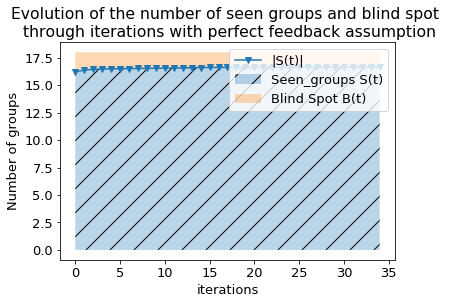

In [ ]:
iterations = range(35)

plt.plot(iterations , (np.mean(seen_perf,0)),'-v',label = '|S(t)|')
plt.fill_between(iterations,min_seen, (np.mean(seen_perf,0)), hatch = '/' ,alpha = 0.3,label = 'Seen_groups S(t)')
plt.fill_between(iterations,(np.mean(seen_perf,0)), max_seen, alpha = 0.3,label = 'Blind Spot B(t)')

plt.xlabel('iterations')
plt.ylabel('Number of groups')
plt.legend(loc='upper right')
plt.title('Evolution of the number of seen groups and blind spot \n through iterations with perfect feedback assumption')


plt.show()


In [ ]:
import scipy.stats as st

def get_CI(results): ### get 95% CI
    array = results
    array = np.array(array)
    CI = []
    for i in range(array.shape[1]):
        a = array[:,i]
        CL,CU = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
        CI = CI + [[CL,CU]]
    return np.array(CI)


In [ ]:
# calculate Delta S (one run as a test)
delta_perf_MF = [(np.mean(seen_perf_MF,0))[i+1] - (np.mean(seen_perf_MF,0))[i] for i in range(len((np.mean(seen_perf_MF,0)))-1)]

In [ ]:
seen_genres_all_array_perf_MF = np.array(seen_perf_MF)

In [ ]:
delta_all_perf_MF = [(seen_genres_all_array_perf_MF)[:,i+1] - ((seen_genres_all_array_perf_MF))[:,i] for i in range(len(seen_genres_all_array_perf_MF[:,0])-1)]

In [ ]:
# calculate Delta S

delta_all_perf_MF = []
for j in range(len(seen_genres_all_array_perf)):
    delta_all_perf_MF += [[(seen_genres_all_array_perf_MF)[j,i+1] - ((seen_genres_all_array_perf_MF))[j,i] for i in range(len(seen_genres_all_array_perf_MF[0])-1)]]

In [ ]:
delta_CI_perf_MF = get_CI(delta_all_perf_MF) ## get CI from all runs


In [ ]:
def bound(iteration,delta): ### Theoretical bound
    return((np.log(1/delta) * 10 * 10)/(2 * iteration))

In [ ]:
x = np.array([i+1 for i in range(34)])
y1 = bound(x,0.95)
y2 = bound(x,0.98)

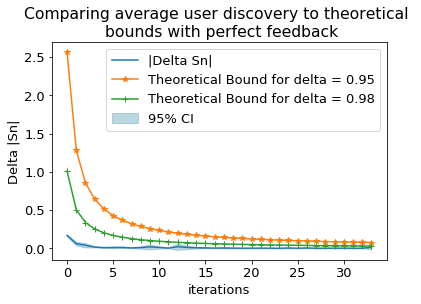

In [ ]:
iterations = range(34)

plt.plot(iterations , delta_perf,'-',label = '|Delta Sn|')
plt.fill_between(iterations, delta_CI_perf[:,0], delta_CI_perf[:,1], color = '#539caf', alpha = 0.4, label = '95% CI')
plt.plot(iterations , y1,'-*',label = 'Theoretical Bound for delta = 0.95')
plt.plot(iterations , y2,'-+',label = 'Theoretical Bound for delta = 0.98')

plt.xlabel('iterations')
plt.ylabel('Delta |Sn|')
plt.legend(loc='upper right')
plt.title('Comparing average user discovery to theoretical \n bounds with perfect feedback')


plt.show()


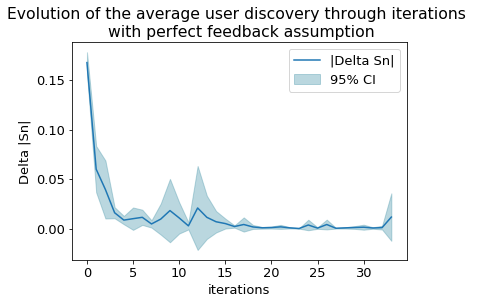

In [ ]:
iterations = range(34)



plt.plot(iterations , delta_perf,'-',label = '|Delta Sn|')
plt.fill_between(iterations, delta_CI_perf[:,0], delta_CI_perf[:,1], color = '#539caf', alpha = 0.4, label = '95% CI')

plt.xlabel('iterations')
plt.ylabel('Delta |Sn|')
plt.legend(loc='upper right')
plt.title('Evolution of the average user discovery through iterations \n with perfect feedback assumption')


plt.show()


In [ ]:
seen_genres_all = []
## relaxation experiment
for iteration in range(5):
    print(iteration)
    full_data = np.copy(Reset_data)
    full_data2 = np.copy(Reset_data)

    seen_genres = []
    np.random.seed(iteration)
    for it in range(35):
        seen_tot = 0
        P,Q = matrix_factorization(full_data , K=10, nsteps=300, alpha=0.01, beta=0.1 )
        predicted = np.dot(P,Q.T)
        selected_data = selection_topn(predicted,10,full_data)
        
        N,M = selected_data.shape
        hit = 0
        
        for i in range(N):
            for j in range(M):
                if (disc(j+1) * Rel(i,int(selected_data[i,j]),complete_matrix)) > 0.5:
                    full_data[i,int(selected_data[i,j])] = complete_matrix[i,int(selected_data[i,j])]
                    
        for i in range(N):
            for j in range(M):
                full_data2[i,int(selected_data[i,j])] = complete_matrix[i,int(selected_data[i,j])]

        for i in range(N):
            user_ratings = full_data2[i]
            seen = calc_seen_card(user_ratings)
            
            seen_tot += seen
        seen_genres += [seen_tot/N]
        print(seen_tot/N)
    seen_genres_all += [seen_genres]

0
16.136754966887416
16.46324503311258
16.500165562913907
16.51158940397351
16.519701986754967
16.52864238410596
16.55844370860927
16.571523178807947
16.57814569536424
16.580132450331124
16.580794701986754
16.58162251655629
16.585596026490066
16.594701986754966
16.595529801324503
16.59701986754967
16.6158940397351
16.62615894039735
16.62682119205298
16.627152317880796
16.627814569536422
16.628311258278146
16.628311258278146
16.63046357615894
16.6341059602649
16.63543046357616
16.636092715231786
16.636754966887416
16.64006622516556
16.640562913907285
16.643377483443707
16.643543046357617
16.643708609271524
16.644039735099337
16.64519867549669
1
16.1385761589404
16.283774834437086
16.36771523178808
16.379801324503312
16.386920529801323
16.39453642384106
16.39701986754967
16.398013245033113
16.399668874172185
16.400827814569535
16.40132450331126
16.402152317880795
16.402649006622518
16.403311258278144
16.404470198675497
16.405298013245034
16.405794701986753
16.40728476821192
16.4114238410

In [ ]:
delta_all = []
seen_genres_all_array = np.array(seen_genres_all)
for j in range(len(seen_genres_all_array)):
    delta_all += [[(seen_genres_all_array)[j,i+1] - ((seen_genres_all_array))[j,i] for i in range(len(seen_genres_all_array[0])-1)]]

In [ ]:
delta_CI = get_CI(delta_all)


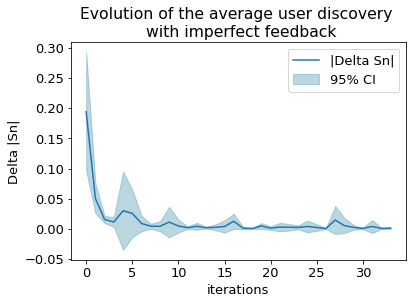

In [ ]:
iterations = range(34)


delta = [(np.mean(seen_genres_all,0))[i+1] - (np.mean(seen_genres_all,0))[i] for i in range(len((np.mean(seen_genres_all,0)))-1)]

plt.plot(iterations , delta,'-',label = '|Delta Sn|')
plt.fill_between(iterations, delta_CI[:,0], delta_CI[:,1], color = '#539caf', alpha = 0.4, label = '95% CI')


plt.xlabel('iterations')
plt.ylabel('Delta |Sn|')
plt.legend(loc='upper right')
plt.title('Evolution of the average user discovery \n with imperfect feedback')


plt.show()


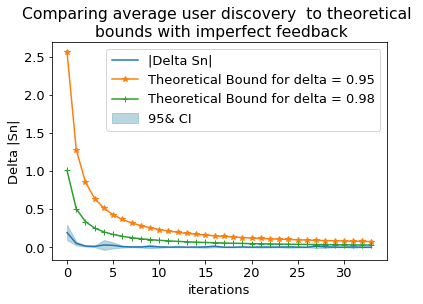

In [ ]:
iterations = range(34)

plt.plot(iterations , delta,'-',label = '|Delta Sn|')
plt.fill_between(iterations, delta_CI[:,0], delta_CI[:,1], color = '#539caf', alpha = 0.4, label = '95& CI')
plt.plot(iterations , y1,'-*',label = 'Theoretical Bound for delta = 0.95')
plt.plot(iterations , y2,'-+',label = 'Theoretical Bound for delta = 0.98')

plt.xlabel('iterations')
plt.ylabel('Delta |Sn|')
plt.legend(loc='upper right')
plt.title('Comparing average user discovery  to theoretical \n bounds with imperfect feedback')


plt.show()


In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)


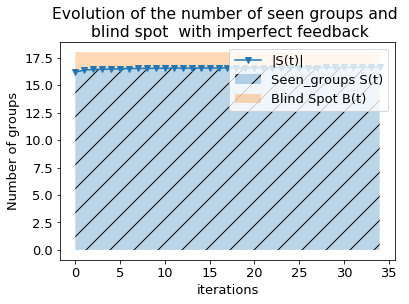

In [ ]:
iterations = range(35)

plt.plot(iterations , (np.mean(seen_genres_all,0)),'-v',label = '|S(t)|')
plt.fill_between(iterations,min_seen, (np.mean(seen_genres_all,0)),alpha = 0.3,hatch = '/',label = 'Seen_groups S(t)')
plt.fill_between(iterations,(np.mean(seen_genres_all,0)), max_seen, alpha = 0.3,label = 'Blind Spot B(t)')

plt.xlabel('iterations')
plt.ylabel('Number of groups')
plt.legend(loc='upper right')
plt.title('Evolution of the number of seen groups and \n blind spot  with imperfect feedback')


plt.show()


# Introducing a Multi-Armed Bandits strategy

In [ ]:
### creating a complete matrix
P,Q = matrix_factorization(full_data , K=10, nsteps=300, alpha=0.001, beta=0.01 )
complete_matrix = np.dot(P,Q.T)
for i in range(n_users):
    percentiles = np.percentile(complete_matrix[i],[20,40,60,80])
    for j in range(n_items):
        if full_data[i,j] != 0:
            complete_matrix[i,j] = full_data[i,j]
        else:
            if complete_matrix[i,j] < percentiles[0]:
                complete_matrix[i,j] = 1
            elif complete_matrix[i,j] < percentiles[1]:
                complete_matrix[i,j] = 2
            elif complete_matrix[i,j] < percentiles[2]:
                complete_matrix[i,j] = 3
            elif complete_matrix[i,j] < percentiles[3]:
                complete_matrix[i,j] = 4
            else:
                complete_matrix[i,j] = 5


In [ ]:
def selection_topn_rand(predicted,n,start_data,p): # Calculate the list of n recommended items with a multi armed bandits exploration
    number_random = int(n * p)
    number_rec = n - number_random
    n_users,n_items = predicted.shape
    selection = np.zeros(shape=(n_users,n))
    for i in range(n_users):
      for j in range(n_items):
        if start_data[i,j] !=0:
          predicted[i,j] = 0
      sorted = np.argsort(-predicted[i])
      top_n = sorted[0:number_rec]
      random = np.random.choice(sorted[number_rec+1:],number_random)
      top_n = top_n.tolist() + random.tolist()
      selection[i] = top_n
    return selection


In [ ]:
## performing the same experiments
seen_genres_all = []

for iteration in range(10):
  print(iteration)
  full_data = np.copy(Reset_data)
  seen_genres = []
  np.random.seed(iteration)
  for it in range(25):
    seen_tot = 0
    P,Q = matrix_factorization(full_data , K=10, nsteps=300, alpha=0.01, beta=0.1 )
    predicted = np.dot(P,Q.T)
    selected_data = selection_topn_rand(predicted,10,full_data,0.1)
    
    N,M = selected_data.shape
    hit = 0
    for i in range(N):
      for j in range(M):
        ### If statement controls the relaxation of assumption 3
        #if (disc(j+1) * Rel(i,int(selected_data[i,j]),complete_matrix)) > 0.5:
        full_data[i,int(selected_data[i,j])] = complete_matrix[i,int(selected_data[i,j])]
    
    for i in range(N):
      user_ratings = full_data[i]
      seen = calc_seen_card(user_ratings)
      
      seen_tot += seen
    seen_genres += [seen_tot/N]
    print(seen_tot/N)
  seen_genres_all += [seen_genres]

In [ ]:
delta_all = []
seen_genres_all_array = np.array(seen_genres_all)
for j in range(len(seen_genres_all_array)):
    delta_all += [[(seen_genres_all_array)[j,i+1] - ((seen_genres_all_array))[j,i] for i in range(len(seen_genres_all_array[0])-1)]]

In [ ]:
max_seen = [19 for i in  range(25)]
min_seen = [0 for i in range(25) ]

In [ ]:
iterations = range(25)

plt.plot(iterations , (np.mean(seen_perf,0)),'-v',label = '|S(t)|')
plt.fill_between(iterations,min_seen, (np.mean(seen_perf,0)), hatch = '/' ,alpha = 0.3,label = 'Seen_groups S(t)')
plt.fill_between(iterations,(np.mean(seen_perf,0)), max_seen, alpha = 0.3,label = 'Blind Spot B(t)')

plt.xlabel('iterations')
plt.ylabel('Number of groups')
plt.legend(loc='upper right')
plt.title('Evolution of the number of seen groups and blind spot \n through iterations using a 0.1-greedy MAB Recommendation strategy')


plt.show()


In [ ]:
# calculate Delta S (one run as a test)
delta_perf = [(np.mean(seen_perf,0))[i+1] - (np.mean(seen_perf,0))[i] for i in range(len((np.mean(seen_perf,0)))-1)]
seen_genres_all_array_perf = np.array(seen_perf)
delta_all_perf = [(seen_genres_all_array_perf)[:,i+1] - ((seen_genres_all_array_perf))[:,i] for i in range(len(seen_genres_all_array_perf[:,0])-1)]
delta_all_perf = []
for j in range(len(seen_genres_all_array_perf)):
    delta_all_perf += [[(seen_genres_all_array_perf)[j,i+1] - ((seen_genres_all_array_perf))[j,i] for i in range(len(seen_genres_all_array_perf[0])-1)]]

delta_CI_perf = get_CI(delta_all_perf) ## get CI from all runs


In [ ]:
x = np.array([i+1 for i in range(24)])
y1 = bound(x,0.95)
y2 = bound(x,0.98)

In [ ]:
for iteration in range(10): #### 20% exploration strategy
  print(iteration)
  full_data = np.copy(Reset_data)
  seen_genres = []
  np.random.seed(iteration)
  for it in range(25):
    seen_tot = 0
    P,Q = matrix_factorization(full_data , K=10, nsteps=300, alpha=0.01, beta=0.1 )
    predicted = np.dot(P,Q.T)
    selected_data = selection_topn_rand(predicted,10,full_data,0.2)
    
    N,M = selected_data.shape
    hit = 0
    for i in range(N):
      for j in range(M):
        ### If statement controls the relaxation of assumption 3
        #if (disc(j+1) * Rel(i,int(selected_data[i,j]),complete_matrix)) > 0.5:
        full_data[i,int(selected_data[i,j])] = complete_matrix[i,int(selected_data[i,j])]
    
    for i in range(N):
      user_ratings = full_data[i]
      seen = calc_seen_card(user_ratings)
      
      seen_tot += seen
    seen_genres += [seen_tot/N]
    print(',',seen_tot/N)
  seen_genres_all += [seen_genres]

In [ ]:
# calculate Delta S (one run as a test)
delta_perf_3 = [(np.mean(seen_perf_3,0))[i+1] - (np.mean(seen_perf_3,0))[i] for i in range(len((np.mean(seen_perf_3,0)))-1)]
seen_genres_all_array_perf_3 = np.array(seen_perf_3)
delta_all_perf_3 = [(seen_genres_all_array_perf_3)[:,i+1] - ((seen_genres_all_array_perf_3))[:,i] for i in range(len(seen_genres_all_array_perf_3[:,0])-1)]
delta_all_perf_3 = []
for j in range(len(seen_genres_all_array_perf_3)):
    delta_all_perf_3 += [[(seen_genres_all_array_perf_3)[j,i+1] - ((seen_genres_all_array_perf_3))[j,i] for i in range(len(seen_genres_all_array_perf_3[0])-1)]]

delta_CI_perf_3 = get_CI(delta_all_perf_3) ## get CI from all runs


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# calculate Delta S (one run as a test)
delta_perf_2 = [(np.mean(seen_perf_2,0))[i+1] - (np.mean(seen_perf_2,0))[i] for i in range(len((np.mean(seen_perf_2,0)))-1)]
seen_genres_all_array_perf_2 = np.array(seen_perf_2)
delta_all_perf_2 = [(seen_genres_all_array_perf_2)[:,i+1] - ((seen_genres_all_array_perf_2))[:,i] for i in range(len(seen_genres_all_array_perf_2[:,0])-1)]
delta_all_perf_2 = []
for j in range(len(seen_genres_all_array_perf_2)):
    delta_all_perf_2 += [[(seen_genres_all_array_perf_2)[j,i+1] - ((seen_genres_all_array_perf_2))[j,i] for i in range(len(seen_genres_all_array_perf_2[0])-1)]]

delta_CI_perf_2 = get_CI(delta_all_perf_2) ## get CI from all runs


In [ ]:
iterations = range(24)


plt.plot(iterations , delta_perf_MF[:24],'-',label = '|Delta Sn| Using Ranking Strategy')
plt.plot(iterations , delta_perf,'-o',label = '|Delta Sn| Using 0.1 - greedy MAB Strategy')

plt.plot(iterations , delta_perf_2,'-x',label = '|Delta Sn| Using 0.2 - greedy MAB Strategy',color = 'black')
plt.plot(iterations , delta_perf_3,'-*',label = '|Delta Sn| Using 0.3 - greedy MAB Strategy', color = 'red')
plt.plot(iterations , y2,'-+',label = 'Theoretical Bound for delta = 0.98',color ='green')

#plt.fill_between(iterations, delta_CI_perf[:,0], delta_CI_perf[:,1], color = '#539caf', alpha = 0.4, label = '95% CI')

plt.xlabel('iterations')
plt.ylabel('Delta |Sn|')
plt.legend(loc='upper right')
plt.title('Evolution of the average user discovery through iterations \n with perfect feedback assumption')


plt.show()


In [ ]:
iterations = range(25)

plt.plot(iterations , (np.mean(seen_perf_2,0)),'-v',label = '|S(t)|')
plt.fill_between(iterations,min_seen, (np.mean(seen_perf_2,0)), hatch = '/' ,alpha = 0.3,label = 'Seen_groups S(t)')

plt.fill_between(iterations,(np.mean(seen_perf_2,0)), max_seen, alpha = 0.3,label = 'Blind Spot B(t)')

plt.xlabel('iterations')
plt.ylabel('Number of groups')
plt.legend(loc='bottom right')
plt.title('Evolution of the number of seen groups and blind spot \n through iterations using a 0.1-greedy MAB Recommendation strategy')


plt.show()


In [ ]:
iterations = range(25)

plt.plot(iterations , (np.mean(seen_perf_2,0)),'-v',label = '|S(t)|')
plt.fill_between(iterations,min_seen, (np.mean(seen_perf_3,0)), hatch = '/' ,alpha = 0.3,label = 'Seen_groups S(t)')

plt.fill_between(iterations,(np.mean(seen_perf_2,0)), max_seen, alpha = 0.3,label = 'Blind Spot B(t)')

plt.xlabel('iterations')
plt.ylabel('Number of groups')
plt.legend(loc='bottom right')
plt.title('Evolution of the number of seen groups and blind spot \n through iterations using a 0.1-greedy MAB Recommendation strategy')


plt.show()
